In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import re
import multiprocessing
import gensim
from gensim.models import word2vec, FastText
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [2]:
amazon = pd.read_csv('amazon_comment_seaweed_chip_result.csv')
amazon = amazon.drop(amazon.columns[0], axis = 1)
walmart = pd.read_csv('walmart.csv') 

In [3]:
amazon.head()

,comment_author,star_rating,comment_date,comment_title,comment
0,Dmitry,1.0 out of 5 stars,"Reviewed in the United States on May 4, 2019",This is very dangerous product ! Do not buy !,"I've been buying this product for a year, I ..."
1,S A,1.0 out of 5 stars,"Reviewed in the United States on September 17,...",Bug eggs in package?!!,Thsee don't expire until December. I opened ...
2,Elisa S.,5.0 out of 5 stars,"Reviewed in the United States on December 17, ...",#1 on my list,The photo shows the seaweed brands I've trie...
3,Ani_Mon,1.0 out of 5 stars,"Reviewed in the United States on July 23, 2017",Oily and stale,The first time I bought these I fell in love...
4,Rachel Humphrey,5.0 out of 5 stars,"Reviewed in the United States on February 4, 2017",The BEST seasoned seaweed makers in the WORLD,I ate the entire box in a week. This stuff i...


In [4]:
# comment_date / star_rating 자르기

def name_cut(x):
    x = x.split('on ')[1]
    return x  

amazon["comment_date"] = amazon["comment_date"].apply(name_cut)

def name_cut(x):
    x = x.split(" out")[0]
    x = float(x)
    return x  

amazon["star_rating"] = amazon["star_rating"].apply(name_cut)

In [5]:
amazon.head()

,comment_author,star_rating,comment_date,comment_title,comment
0,Dmitry,1.0,"May 4, 2019",This is very dangerous product ! Do not buy !,"I've been buying this product for a year, I ..."
1,S A,1.0,"September 17, 2018",Bug eggs in package?!!,Thsee don't expire until December. I opened ...
2,Elisa S.,5.0,"December 17, 2018",#1 on my list,The photo shows the seaweed brands I've trie...
3,Ani_Mon,1.0,"July 23, 2017",Oily and stale,The first time I bought these I fell in love...
4,Rachel Humphrey,5.0,"February 4, 2017",The BEST seasoned seaweed makers in the WORLD,I ate the entire box in a week. This stuff i...


In [6]:
# 아마존 + 월마트 데이터 합치기

review = pd.concat([amazon['comment'], walmart['comment']], axis = 0) 
score = pd.concat([amazon['star_rating'], walmart['score']], axis = 0) 
author = pd.concat([amazon['comment_author'], walmart['author']], axis = 0)
date = pd.concat([amazon['comment_date'], walmart['date']], axis = 0)
title = pd.concat([amazon['comment_title'], walmart['title']], axis = 0)

review = pd.DataFrame({'date': date, 'title' : title, 'review': review, 'score': score, 'author': author})

## 전처리

In [93]:
stop_words = set(stopwords.words("english"))

contraction_mapping = {"won't": "will not",  "ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", 
                       
                       "could've": "could have", "couldn't": "could not", "didn't": "did not", "doesn't": "does not", "don't": "do not", 
                       
                       "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", 
                       
                       "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                       
                       "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have", "I'm": "I am", 
                       
                       "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
                       
                       "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                       
                       "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam", 
                       
                       "mayn't": "may not", "might've": "might have","mightn't": "might not", "mightn't've": "might not have", 
                       
                       "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", 
                       
                       "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", 
                       
                       "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                       
                       "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", 
                       
                       "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", 
                       
                       "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", 
                       
                       "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", 
                       
                       "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                       
                       "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", 
                       
                       "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                       
                       "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", 
                       
                       "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", 
                       
                       "when've": "when have", "where'd": "where did", "where's": "where is","where've": "where have", "who'll": "who will", 
                       
                       "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": 
                       
                       "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", 
                       
                       "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       
                       "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                       
                       "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", 
                       
                       "you're": "you are", "you've": "you have"}

In [94]:
# 전처리 함수

def preprocess(text):
    values = "".join(str(i) for i in str(text))
    no_capitals = str(values).lower() #모든 값에 대해 소문자 처리
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in no_capitals.split(" ")])
    tokenized = word_tokenize(newString) #string에서 nltk 이용, 키워드단어 추출
    only_english = re.sub('[^a-zA-Z]', ' ', str(tokenized)).split() #기호, 부호 예외처리
    token = [token for token in only_english if len(token) > 1]
    no_stopwords = [t for t in token if t not in stop_words]
    
    return ", ".join(no_stopwords)

In [95]:
# 전처리 함수 적용

review['cleaned_review'] = review['review'].apply(lambda x: preprocess(x))

In [96]:
review.head()

,date,title,review,score,author,cleaned_review
0,"May 4, 2019",This is very dangerous product ! Do not buy !,"I've been buying this product for a year, I ...",1.0,Dmitry,"buying, product, year, bought, many, times, wo..."
1,"September 17, 2018",Bug eggs in package?!!,Thsee don't expire until December. I opened ...,1.0,S A,"thsee, expire, december, opened, today, found,..."
2,"December 17, 2018",#1 on my list,The photo shows the seaweed brands I've trie...,5.0,Elisa S.,"photo, shows, seaweed, brands, tried, order, p..."
3,"July 23, 2017",Oily and stale,The first time I bought these I fell in love...,1.0,Ani_Mon,"first, time, bought, fell, love, types, seawee..."
4,"February 4, 2017",The BEST seasoned seaweed makers in the WORLD,I ate the entire box in a week. This stuff i...,5.0,Rachel Humphrey,"ate, entire, box, week, stuff, delicious, enjo..."


In [97]:
# 긍부정 매핑

df = review
X = df['cleaned_review']
y_dict = {1.0:0, 2.0:0, 3.0:1, 4.0:1, 5.0:1}
y = df['score'].map(y_dict)

df['score'] = df['score'].map(y_dict)

positive_doc = df['cleaned_review'].groupby(df['score']).get_group(1).apply(lambda x : x.replace(', ', ' ').split())
negative_doc = df['cleaned_review'].groupby(df['score']).get_group(0).apply(lambda x : x.replace(', ', ' ').split())

In [98]:
tokenized_doc = review['cleaned_review'].apply(lambda x : x.replace(', ', ' ').split())

In [99]:
# pos tagging

tagged = []

for t in tokenized_doc:
    tagged.append(nltk.pos_tag(t))

pos_tag = pd.DataFrame({'tagged': tagged })
pos_tag.head()

,tagged
0,"[(buying, VBG), (product, NN), (year, NN), (bo..."
1,"[(thsee, NN), (expire, NN), (december, NN), (o..."
2,"[(photo, NN), (shows, NNS), (seaweed, VBP), (b..."
3,"[(first, JJ), (time, NN), (bought, VBN), (fell..."
4,"[(ate, NN), (entire, JJ), (box, NN), (week, NN..."


In [100]:
# 명사만 추출

def extract_pos(tagged):
    noun = []
    for (word, tag) in tagged:
        if tag == 'NN' or tag == 'NNS':
            noun.append(word)
    return noun

pos_tag['tagged'].map(extract_pos).head()

0    [product, year, times, start, today, something...
1    [thsee, expire, december, today, bug, eggs, re...
2    [photo, shows, brands, order, preference, jayo...
3    [time, types, snacks, difference, time, time, ...
4    [ate, box, week, seaweed, folks, brands, way, ...
Name: tagged, dtype: object

In [101]:
pos_tag['noun'] = pos_tag['tagged'].map(extract_pos)
pos_tag.head()

,tagged,noun
0,"[(buying, VBG), (product, NN), (year, NN), (bo...","[product, year, times, start, today, something..."
1,"[(thsee, NN), (expire, NN), (december, NN), (o...","[thsee, expire, december, today, bug, eggs, re..."
2,"[(photo, NN), (shows, NNS), (seaweed, VBP), (b...","[photo, shows, brands, order, preference, jayo..."
3,"[(first, JJ), (time, NN), (bought, VBN), (fell...","[time, types, snacks, difference, time, time, ..."
4,"[(ate, NN), (entire, JJ), (box, NN), (week, NN...","[ate, box, week, seaweed, folks, brands, way, ..."


# doc2vec 시각화

In [102]:
# doc2vec vector 생성

def tagged_document(list_of_list_of_words):
   for i, list_of_words in enumerate(list_of_list_of_words):
      yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])

data_for_training = list(tagged_document(tokenized_doc))

doc2vec = gensim.models.doc2vec.Doc2Vec(vector_size=64, min_count=2, epochs=30)
doc2vec.build_vocab(data_for_training)
doc2vec.train(data_for_training, total_examples=doc2vec.corpus_count, epochs=doc2vec.epochs)

In [103]:
# 긍정 / 부정 결과 데이터로 추출된 키워드 기준

keys = ['delicious', 'snack', 'tasty', 'favorite', 'calorie', 'calories', 'kids', 'son', 'addictive', 'daughter',
        'flavors', 'fast', 'easy', 'bbq', 'value', 'keep', 'addicted', 'enough', 'crunchy', 'seem', 
        'date', 'opened', 'boxes', 'fishy', 'tasted', 'cardboard', 'expired', 'threw', 'hard', 'crushed', 'box',
        'disgusting', 'fish', 'received', 'sorry', 'nasty', 'crumbs', 'yuck', 'stale']
        
embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in doc2vec.wv.most_similar(word, topn=15):
        words.append(similar_word)
        embeddings.append(doc2vec[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [50]:
# TSNE plot - 전체 데이터 분포 확인

# n_components : 차원. default는 2.
# perplexity : 가장 가까운 이웃 갯수. 보통 5~50. default는 30.
# init : embedding 초기화 방법. random과 pca 중에서 선택. pca가 보다 안정적. default는 random.
# n_iter : 최적화에 사용할 반복 횟수

tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

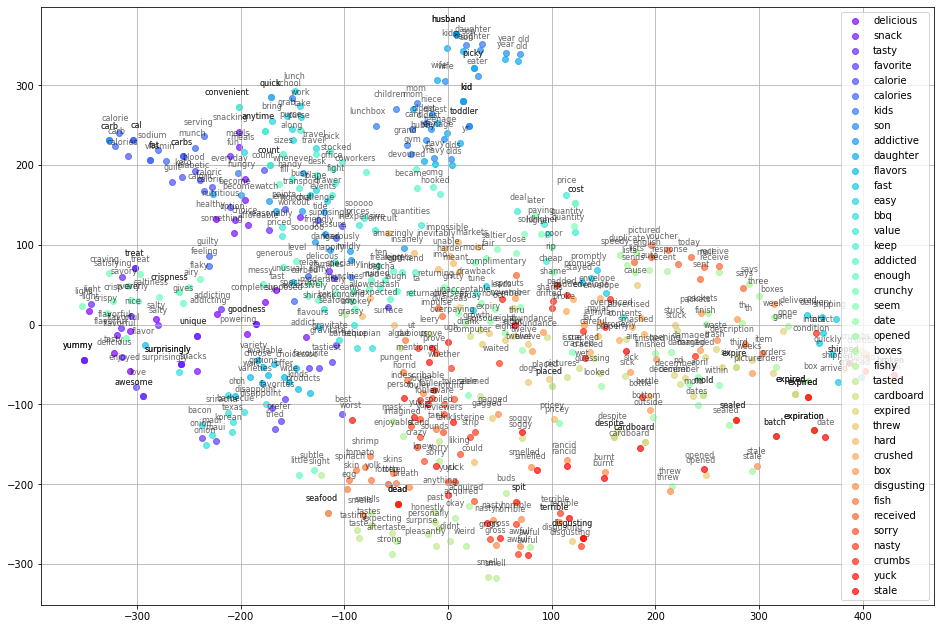

In [52]:
def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(16, 11))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            ann = '   {}\n'.format(word)
            plt.annotate(word, alpha=0.6, xy=(x[i], y[i]), xytext=(10, 10), 
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.grid(True)
    plt.savefig("cluster.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words(keys, embeddings_en_2d, word_clusters)

## word2vec / 시각화

In [63]:
# word2vec / fasttext 사용 비교

# 64차원으로 임베딩
# 명사만 사용
# 단어 최소 출현 횟수: 2
word2vec = Word2Vec(tokenized_doc, sg=0, min_count=2, size=64)
# fasttext = FastText(sentences, min_count=1, size=64)

# cbow를 선택: 리뷰는 집약적으로 표현한 데이터이므로
# 전체적인 통계 정보나 subword의 의미를 파악하기보다는 각 단어의 유사도를 판단하는 것이 중요하다고 생각

In [54]:
# word2vec 시각화 함수

from sklearn.decomposition import PCA

# tsne plot for below word
def tsne_plot(for_word, w2v_model):
    # trained word2vec model dimention
    sns.set_style('whitegrid')
    dim_size = w2v_model.wv.vectors.shape[1]

    arrays = np.empty((0, dim_size), dtype='f')
    word_labels = [for_word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, w2v_model.wv.__getitem__([for_word]), axis=0)

    # gets list of most similar words
    sim_words = w2v_model.wv.most_similar(for_word, topn=25)

    # adds the vector for each of the closest words to the array
    for wrd_score in sim_words:
        wrd_vector = w2v_model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('black')
        arrays = np.append(arrays, wrd_vector, axis=0)

    #---------------------- Apply PCA and tsne to reduce dimention --------------

    # fit 2d PCA model to the similar word vectors
    model_pca = PCA(n_components = 10).fit_transform(arrays)

    # Finds 2d coordinates t-SNE
    np.set_printoptions(suppress=True)
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(model_pca)

    # Sets everything up to plot
    df_plot = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words_name': word_labels,
                       'words_color': color_list})

    #------------------------- tsne plot Python -----------------------------------

    # plot dots with color and position
    plt.figure(figsize=(12, 7))
    plot_dot = sns.regplot(data=df_plot,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df_plot['words_color']
                                 }
                    )

    # Adds annotations with color one by one with a loop
    for line in range(0, df_plot.shape[0]):
         plot_dot.text(df_plot["x"][line],
                 df_plot['y'][line],
                 '  ' + df_plot["words_name"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df_plot['words_color'][line],
                 weight='normal'
                ).set_size(15)

    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)

    plt.title('t-SNE visualization for word "{}'.format(for_word.title()) +'"')

## 패키징 키워드: 부서지기 쉬움

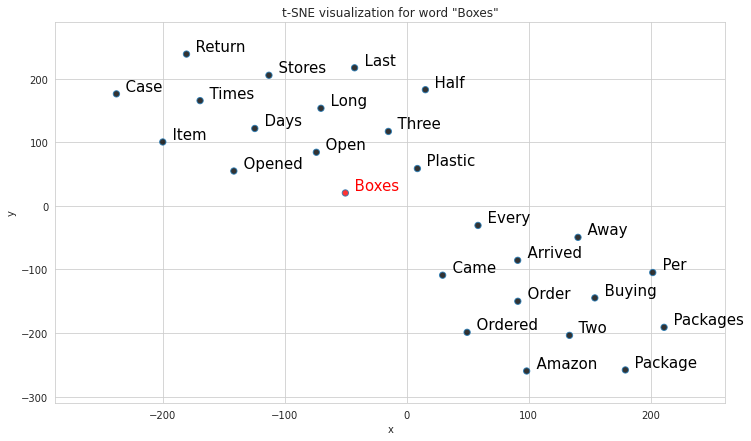

In [64]:
tsne_plot(for_word='boxes', w2v_model=word2vec)

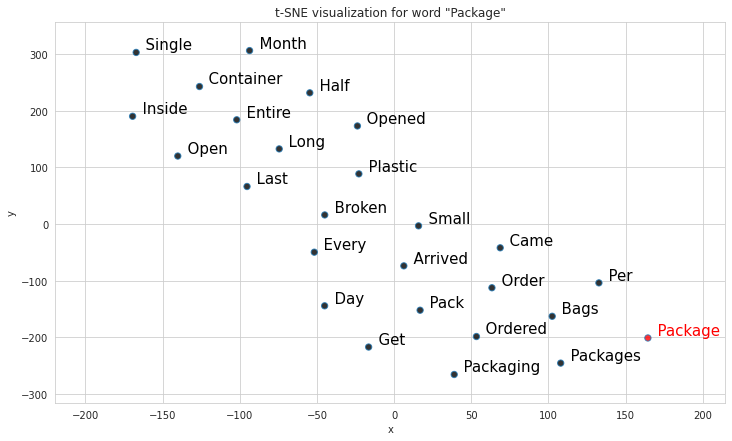

In [66]:
tsne_plot(for_word='package', w2v_model=word2vec)

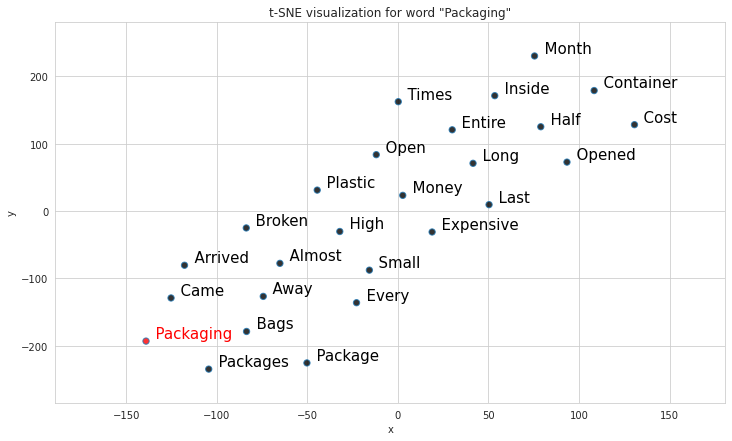

In [67]:
tsne_plot(for_word='packaging', w2v_model=word2vec)

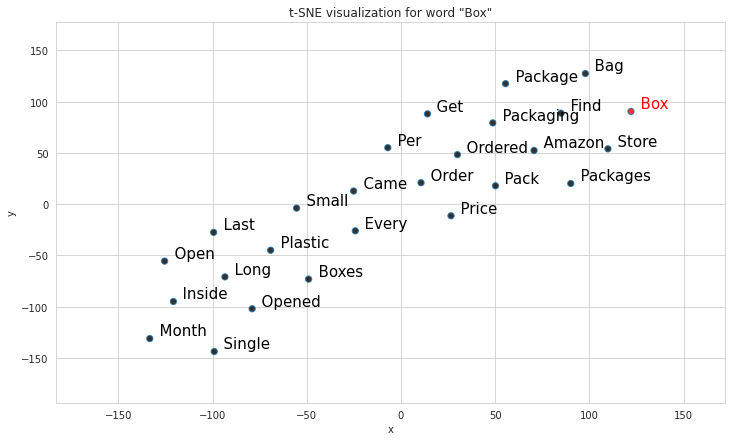

In [69]:
tsne_plot(for_word='box', w2v_model=word2vec)

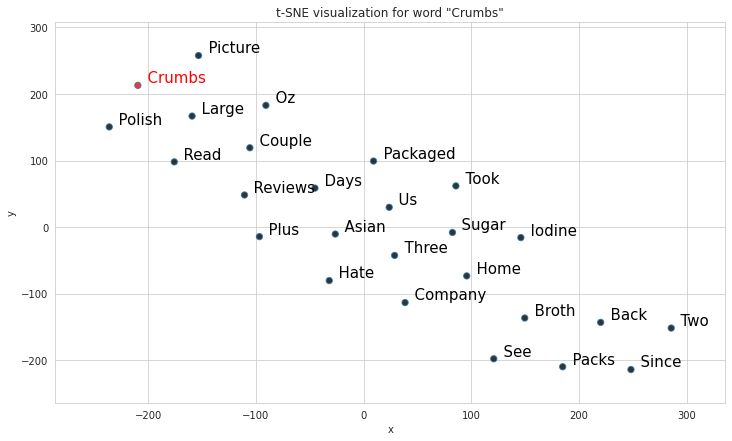

In [68]:
tsne_plot(for_word='crumbs', w2v_model=word2vec)

## 패키징: 신선도 키워드

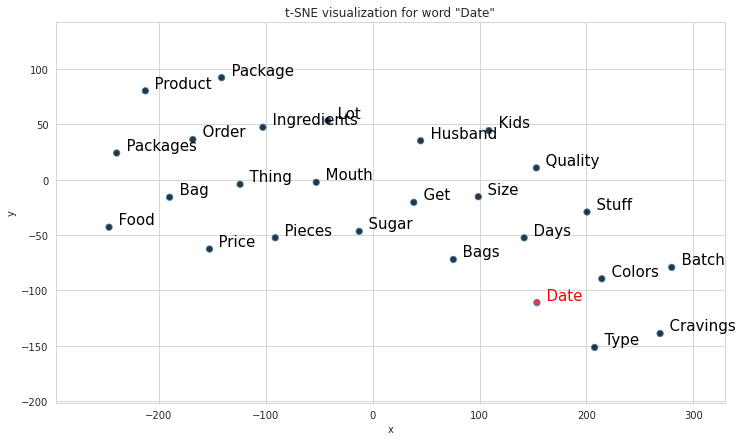

In [55]:
tsne_plot(for_word='date', w2v_model=word2vec)

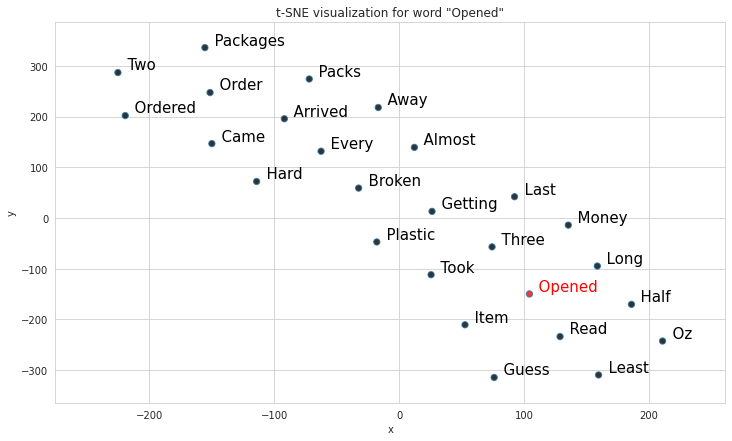

In [71]:
tsne_plot(for_word='opened', w2v_model=word2vec)

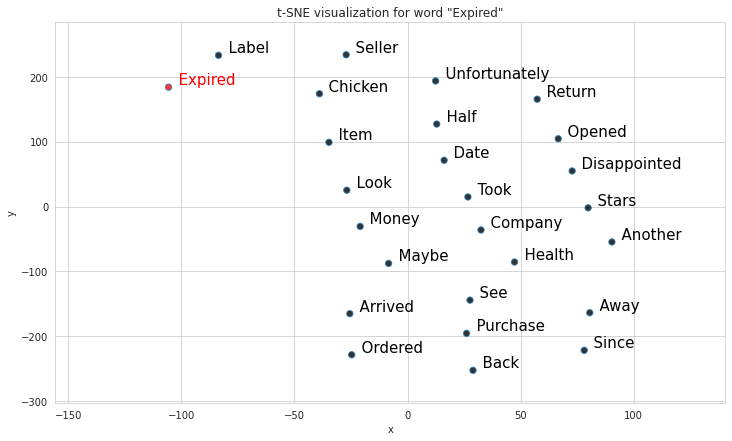

In [70]:
tsne_plot(for_word='expired', w2v_model=word2vec)

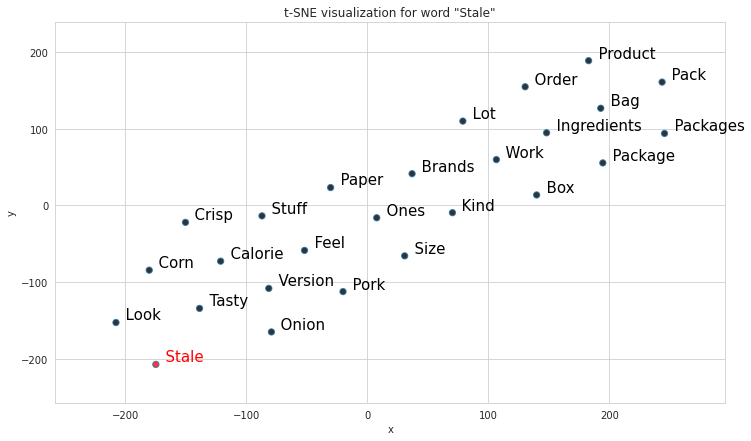

In [59]:
tsne_plot(for_word='stale', w2v_model=word2vec)

## 홍보: 건강, 가족 키워드

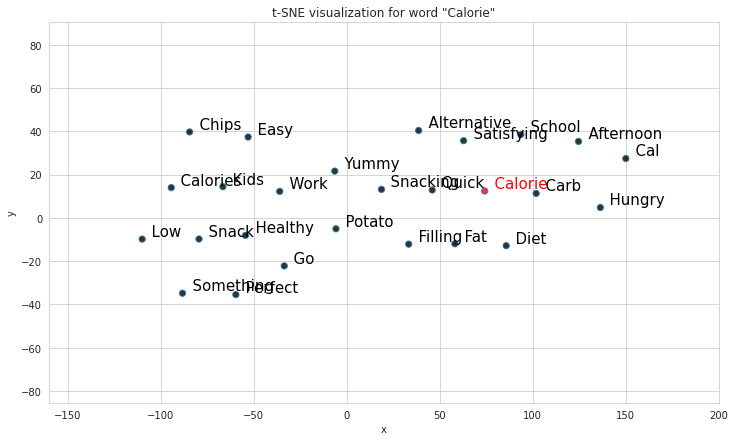

In [72]:
tsne_plot(for_word='calorie', w2v_model=word2vec)

## 패키징: 간편성 키워드

In [76]:
# word2vec 시각화 함수

from sklearn.decomposition import PCA

# tsne plot for below word
def tsne_plot(for_word, w2v_model):
    # trained word2vec model dimention
    sns.set_style('whitegrid')
    dim_size = w2v_model.wv.vectors.shape[1]

    arrays = np.empty((0, dim_size), dtype='f')
    word_labels = [for_word]
    color_list  = ['blue']

    # adds the vector of the query word
    arrays = np.append(arrays, w2v_model.wv.__getitem__([for_word]), axis=0)

    # gets list of most similar words
    sim_words = w2v_model.wv.most_similar(for_word, topn=25)

    # adds the vector for each of the closest words to the array
    for wrd_score in sim_words:
        wrd_vector = w2v_model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('black')
        arrays = np.append(arrays, wrd_vector, axis=0)

    #---------------------- Apply PCA and tsne to reduce dimention --------------

    # fit 2d PCA model to the similar word vectors
    model_pca = PCA(n_components = 10).fit_transform(arrays)

    # Finds 2d coordinates t-SNE
    np.set_printoptions(suppress=True)
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(model_pca)

    # Sets everything up to plot
    df_plot = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words_name': word_labels,
                       'words_color': color_list})

    #------------------------- tsne plot Python -----------------------------------

    # plot dots with color and position
    plt.figure(figsize=(12, 7))
    plot_dot = sns.regplot(data=df_plot,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df_plot['words_color']
                                 }
                    )

    # Adds annotations with color one by one with a loop
    for line in range(0, df_plot.shape[0]):
         plot_dot.text(df_plot["x"][line],
                 df_plot['y'][line],
                 '  ' + df_plot["words_name"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df_plot['words_color'][line],
                 weight='normal'
                ).set_size(15)

    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)

    plt.title('t-SNE visualization for word "{}'.format(for_word.title()) +'"')

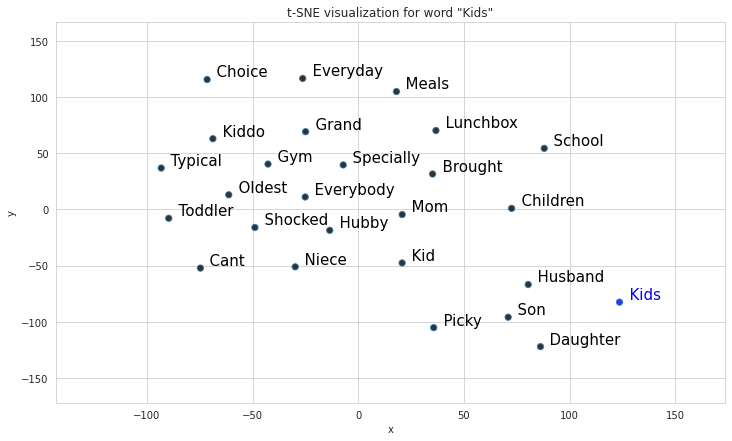

In [77]:
tsne_plot(for_word='kids', w2v_model=doc2vec)

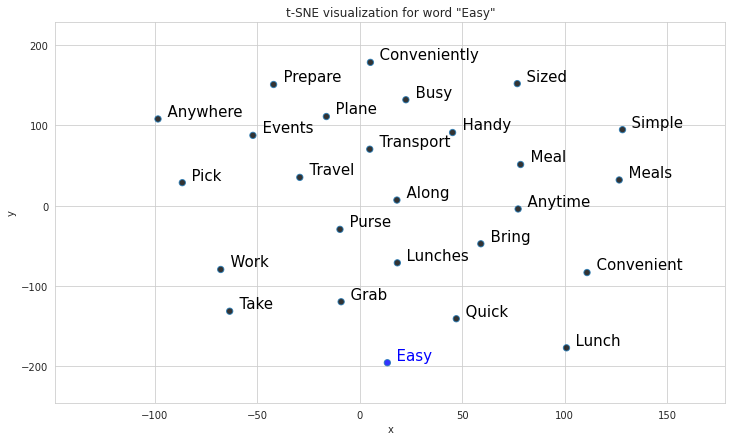

In [78]:
tsne_plot(for_word='easy', w2v_model=doc2vec)

## 맛 키워드

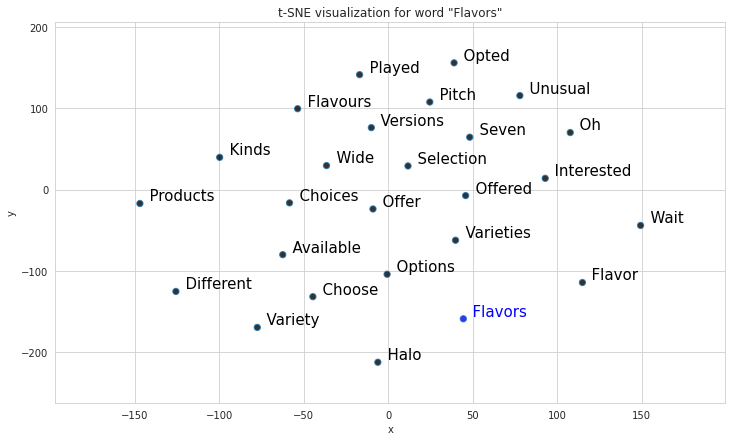

In [79]:
tsne_plot(for_word='flavors', w2v_model=doc2vec)

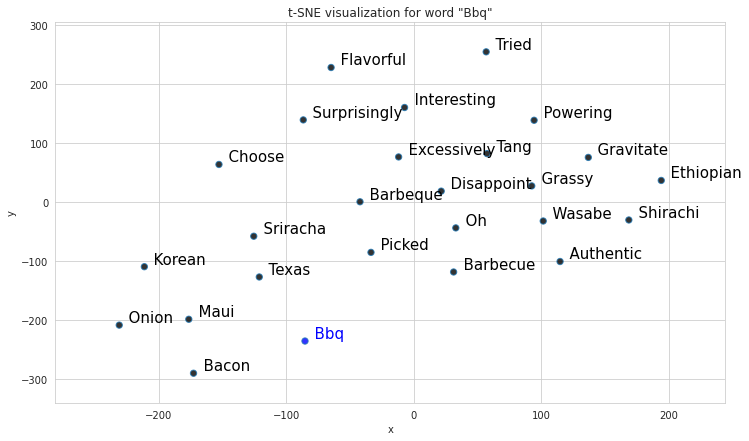

In [83]:
tsne_plot(for_word='bbq', w2v_model=doc2vec)

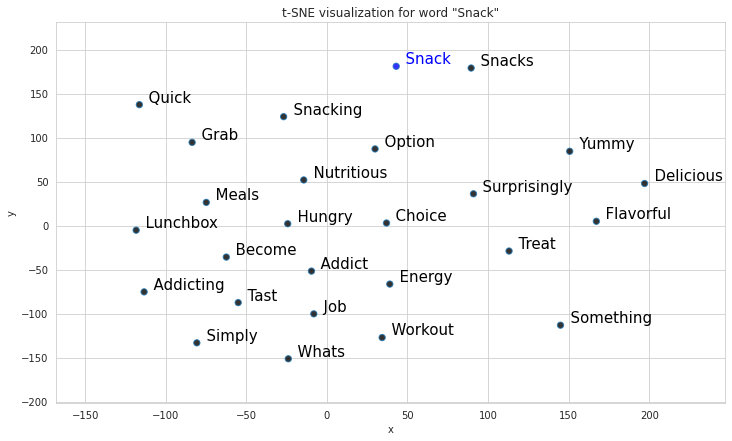

In [80]:
tsne_plot(for_word='snack', w2v_model=doc2vec)

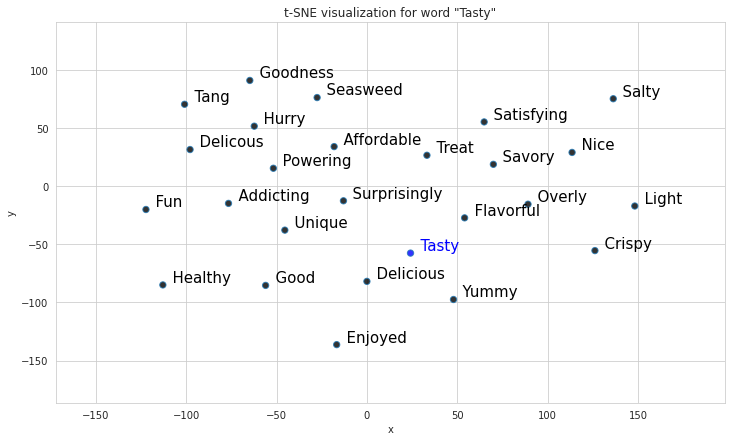

In [81]:
tsne_plot(for_word='tasty', w2v_model=doc2vec)

### flavors, delicious, tasty, tasted 긍정 + fish, smell, fishy 부정 = word2vec 결과


In [44]:
doc2vec.wv.most_similar(positive = ['flavors', 'delicious', 'tasty', 'tasted'], negative = ['fish', 'smell', 'fishy'], topn=10)

[('yummy', 0.6494112014770508),
 ('snacking', 0.5349876284599304),
 ('choices', 0.5310746431350708),
 ('flavorful', 0.5309418439865112),
 ('choose', 0.5210024118423462),
 ('soooooo', 0.519794762134552),
 ('option', 0.5168310403823853),
 ('convenient', 0.5010614395141602),
 ('options', 0.5000500082969666),
 ('pick', 0.4998275637626648)]

In [45]:
words = [words for words, coef in doc2vec.wv.most_similar(positive = ['flavors', 'delicious', 'tasty', 'tasted'], negative = ['fish', 'smell', 'fishy'])]
similar = [coef for words, coef in doc2vec.wv.most_similar(positive = ['flavors', 'delicious', 'tasty', 'tasted'], negative = ['fish', 'smell', 'fishy'])]
df = pd.DataFrame({'Word': words, 'Similarity': similar})
df.head(20)

,Word,Similarity
0,yummy,0.649411
1,snacking,0.534988
2,choices,0.531075
3,flavorful,0.530942
4,choose,0.521002
5,soooooo,0.519795
6,option,0.516831
7,convenient,0.501061
8,options,0.500050
9,pick,0.499828
